# Variational autoencoder (VAE) - Generative model
- from https://blog.keras.io/building-autoencoders-in-keras.html
- What is a variational autoencoder? It's a type of autoencoder with added constraints on the encoded representations being learned. 
- More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. 
- If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

- how does it work?
  - First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. 
  - Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor.
  - Finally, a decoder network maps these latent space points back to the original input data.

- difference between VAE and standard autoencoder:
  - The main benefit of a variational autoencoder is that we're capable of learning smooth latent state representations of the input data. For standard autoencoders, we simply need to learn an encoding which allows us to reproduce the input. 
  - As you can see in the left-most figure (https://www.jeremyjordan.me/variational-autoencoders/), focusing only on reconstruction loss does allow us to separate out the classes (in this case, MNIST digits) which should allow our decoder model the ability to reproduce the original handwritten digit, but there's an uneven distribution of data within the latent space. 
  - In other words, there are areas in latent space which don't represent any of our observed data.

## A simple VAE model with MNIST

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# original_dim = 28 * 28
# intermediate_dim = 64
# latent_dim = 2

inputs = keras.Input(shape=(28*28,))
h = layers.Dense(64, activation='relu')(inputs)
z_mean = layers.Dense(2)(h)
z_log_sigma = layers.Dense(2)(h)

In [4]:
z_mean.shape, z_log_sigma.shape

(TensorShape([None, 2]), TensorShape([None, 2]))

- We can use these parameters to sample new similar points from the latent space:
- layers.Lambda(func_name): Wraps arbitrary expressions as a Layer object. Inherits from Layer, Module

In [5]:
from tensorflow.keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma]) 

In [6]:
z.shape

TensorShape([None, 2])

- Finally, we can map these sampled latent points back to reconstructed inputs:

In [7]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           50240       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            130         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2)            130         ['dense[0][0]']                  
                                                                                            

In [8]:
encoder.output_shape, encoder.input_shape

([(None, 2), (None, 2), (None, 2)], (None, 784))

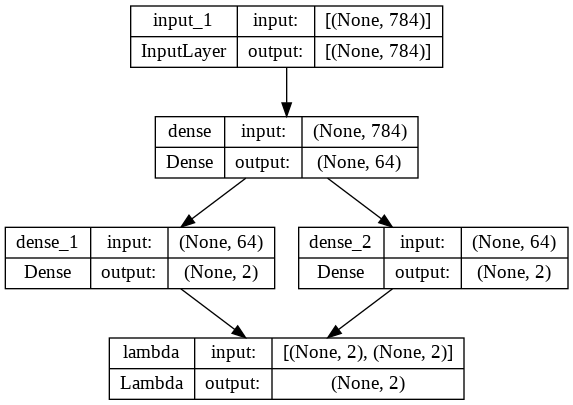

In [9]:
keras.utils.plot_model(encoder, "encoder_info.png", show_shapes=True)

In [10]:
encoder.output_shape

[(None, 2), (None, 2), (None, 2)]

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 64)                192       
                                                                 
 dense_4 (Dense)             (None, 784)               50960     
                                                                 
Total params: 51,152
Trainable params: 51,152
Non-trainable params: 0
_________________________________________________________________


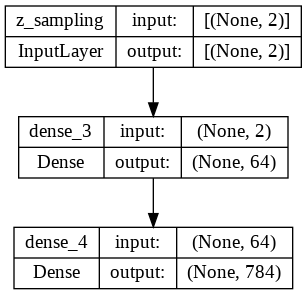

In [11]:
# Create decoder
latent_inputs = keras.Input(shape=(2,), name='z_sampling')
x = layers.Dense(64, activation='relu')(latent_inputs)
outputs = layers.Dense(28*28, activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()
keras.utils.plot_model(decoder, "decoder_info.png", show_shapes=True)

In [12]:
decoder.input_shape, decoder.output_shape

((None, 2), (None, 784))

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               50500     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               51152     
                                                                 
Total params: 101,652
Trainable params: 101,652
Non-trainable params: 0
_________________________________________________________________


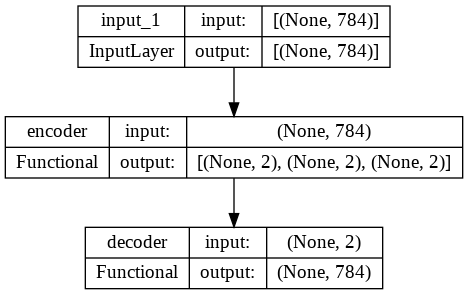

In [13]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])    # take only z-value
vae = keras.Model(inputs, outputs, name='vae_mlp')
vae.summary()
keras.utils.plot_model(vae, "vae_info.png", show_shapes=True)

In [ ]:
z_mean, z_log_sigma, z

(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_4')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_5')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'lambda')>)

In [ ]:
inputs, outputs

(<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'decoder')>)

- What we've done so far allows us to instantiate 3 models:
  - an end-to-end autoencoder mapping inputs to reconstructions
  - an encoder mapping inputs to the latent space
  - a generator that can take points on the latent space and will output the corresponding reconstructed samples.
- We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [ ]:
# for exercise
# By default, loss functions return one scalar loss value per input sample, e.g.
tf.keras.losses.mean_squared_error(tf.ones((2, 2,)), tf.zeros((2, 2)))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>

- As it turns out, by placing a larger emphasis on the KL divergence term we're also implicitly enforcing that the learned latent dimensions are uncorrelated (through our simplifying assumption of a diagonal covariance matrix).

In [ ]:
# original code
# reconstruction_loss = keras.losses.mse(inputs, outputs)
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs) # mean over all 784 pixels
reconstruction_loss *= 28*28    # loss for the entire input image shape (28*28)
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=1)
beta = 2.0
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)  # more weight on KL_loss 

# All loss functions in Keras always take two parameters y_true and y_pred.
# If you have more (namely z_log_var and z_mean, which are not available to the loss functions)
# here, you should use model.add_loss(). (no restriction)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam') 

print(reconstruction_loss.shape, kl_loss.shape, vae_loss.shape)


(None,) (None,) ()


In [ ]:
'''
# try this alternative (not working)
def vae_loss(inputs, outputs):
    reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs) # mean over all 784 pixels
    reconstruction_loss *= 28*28    # loss for the entire input image shape (28*28)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=1)
    beta = 2.0
    vae_loss = K.mean(reconstruction_loss + beta * kl_loss)  # more weight on KL_loss ?
    return vae_loss

vae.compile(optimizer='adam', loss=vae_loss)
'''

"\n# try this alternative (not working)\ndef vae_loss(inputs, outputs):\n    reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs) # mean over all 784 pixels\n    reconstruction_loss *= 28*28    # loss for the entire input image shape (28*28)\n    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=1)\n    beta = 2.0\n    vae_loss = K.mean(reconstruction_loss + beta * kl_loss)  # more weight on KL_loss ?\n    return vae_loss\n\nvae.compile(optimizer='adam', loss=vae_loss)\n"

In [ ]:
'''
# try this, too (it works ok ! but seems that only one is recognized)
# reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs) # mean over all 784 pixels
# reconstruction_loss *= 28*28    # loss for the entire input image shape (28*28)

kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=1)
beta = 2.0
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)  # more weight on KL_loss 

vae.add_loss(K.mean(kl_loss)/784.)
vae.compile(optimizer='adam', loss='binary_crossentropy')
'''

"\n# try this, too (it works ok ! but seems that only one is recognized)\n# reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs) # mean over all 784 pixels\n# reconstruction_loss *= 28*28    # loss for the entire input image shape (28*28)\n\nkl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=1)\nbeta = 2.0\nvae_loss = K.mean(reconstruction_loss + beta * kl_loss)  # more weight on KL_loss ?\n\nvae.add_loss(K.mean(kl_loss)/784.)\nvae.compile(optimizer='adam', loss='binary_crossentropy')\n"

- train with MNIST dataset

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=20,
        batch_size=3,
        validation_data=(x_test, x_test))

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/20
20000/20000 [==============================] - 64s 3ms/step - loss: 168.6849 - val_loss: 161.8761
Epoch 2/20
20000/20000 [==============================] - 60s 3ms/step - loss: 159.4170 - val_loss: 157.7988
Epoch 3/20
20000/20000 [==============================] - 61s 3ms/step - loss: 156.6983 - val_loss: 156.0533
Epoch 4/20
20000/20000 [==============================] - 59s 3ms/step - loss: 155.3194 - val_loss: 155.7071
Epoch 5/20
20000/20000 [==============================] - 62s 3ms/step - loss: 154.4127 - val_loss: 154.5511
Epoch 6/20
20000/20000 [==============================] - 65s 3ms/step - loss: 153.7389 - val_loss: 153.2755
Epoch 7/20
20000/20000 [==============================] - 64s 3ms/step - loss: 153.2331 - val_loss: 153.1499
Epoch 8/20
20000/20000 [==============================] - 63s 3ms/step - loss: 152.7869 - val_loss: 152.1389
Epoch 9/20
20000/20000 [==============================] - 59s 3

- Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:

Shapes of x_test_encoded and y_test:  (3, 10000, 2) (10000,)


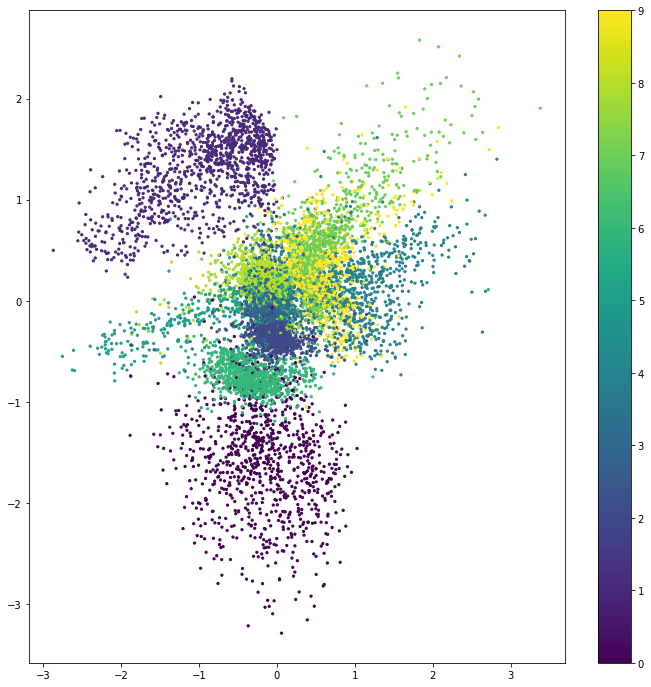

In [ ]:
import matplotlib.pyplot as plt

x_test_encoded = np.array(encoder.predict(x_test, batch_size=16))
print("Shapes of x_test_encoded and y_test: ", x_test_encoded.shape, y_test.shape)

plt.figure(figsize=(12, 12))
x_test_encoded.shape          # 3 (mean, log_sigma, z) * 10000 * 2
x_test_encoded[0,:,1].shape, y_test.shape

plt.scatter(x_test_encoded[2,:,0], x_test_encoded[2,:,1], c=y_test, s=5)
plt.colorbar()
plt.show()

- Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

- Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

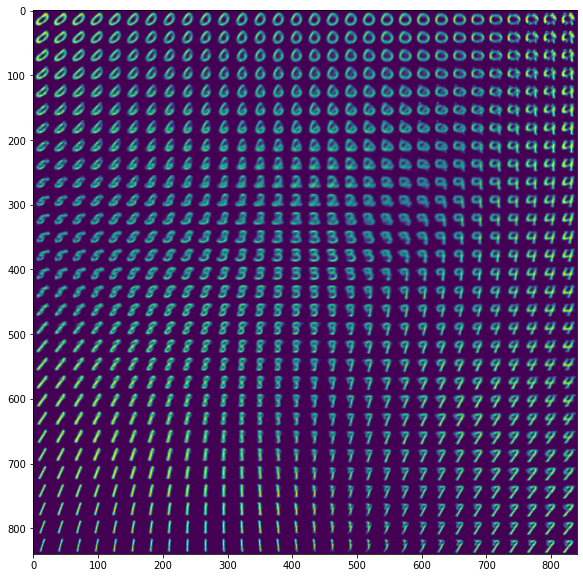

In [ ]:
# Display a 2D manifold of the digits

from scipy.stats import norm

n = 30         # figure with 15x15 digits
figure = np.zeros((28 * n, 28 * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28,
               j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

- You will get different distributions and different effect by giving various values of beta in the loss.
- For more information, see
  - https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73 or
  - https://www.jeremyjordan.me/variational-autoencoders/

# Exercise

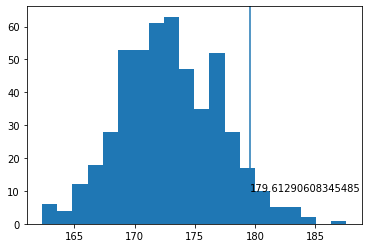

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

mean=172.7815
std=4.1532
N = 500

results=norm.rvs(mean, std, size=N)
pct_5 = norm.ppf(.95, mean, std)    # percent point function (inverse of cdf - percentiles)
plt.hist(results, bins=20)
plt.axvline(pct_5)
plt.annotate(pct_5, xy=(pct_5, 10))
plt.show()

In [ ]:
n = 15
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

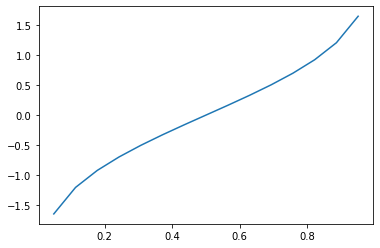

In [ ]:
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
plt.plot(np.linspace(0.05, 0.95, n), grid_x)

In [ ]:
rv = norm(loc = 0, scale = 1) # 표준정규확률객체 만들기
rv.ppf(0.5), rv.ppf(0.6)      # 0.5, 0.6 분위수값 (cumulative prob. function 에서)

(0.0, 0.2533471031357997)

In [ ]:
norm.ppf(0.6, 0, 1)    # 분위수(quartile) 0.6, mean =0, sigma = 1 normal

0.2533471031357997

In [ ]:
norm.ppf (0.05), norm.ppf(0.5), norm.ppf (0.95)

(-1.6448536269514729, 0.0, 1.6448536269514722)

In [ ]:
norm.ppf (np.linspace(0.05, 0.95, 10))

array([-1.64485363, -1.03643339, -0.67448975, -0.38532047, -0.12566135,
        0.12566135,  0.38532047,  0.67448975,  1.03643339,  1.64485363])

- KL diveregence (or Relative Entropy)
  - The relative entropy from Q to P is often denoted D_KL(P||Q).
  - KL(P||Q) = H(P,Q) - H(P)
  - In the context of machine learning, D_KL(P||Q) is often called the information gain achieved if P would be used instead of Q which is currently used.
  - Relative entropy D_KL(P||Q) can be thought of as something like a measurement of how far the distribution Q is from the distribution P. 
  - The cross-entropy H(P,Q) is itself such a measurement, but it has the defect that H(P,P)=:H(P) isn't zero, so we subtract H(P) to make D_KL(P||Q) agree more closely with our notion of distance. (Unfortunately it still isn't symmetric.)

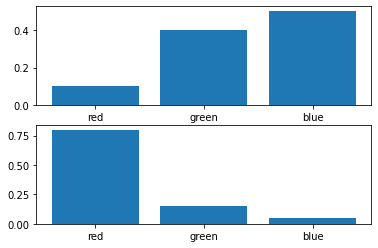

In [ ]:
from matplotlib import pyplot
# define distributions
events = ['red', 'green', 'blue']
p = [0.10, 0.40, 0.50]
q = [0.80, 0.15, 0.05]

pyplot.subplot(2,1,1)
pyplot.bar(events, p)
pyplot.subplot(2,1,2)
pyplot.bar(events, q)
pyplot.show()

In [ ]:
# calculate the kl divergence : KL(P||Q) = H(P,Q) - H(P)
def kl_divergence(p, q):
    p, q = np.array(p), np.array(q)
    kl_div = p * np.log(p/q)
    return np.sum(kl_div)

In [ ]:
# calculate (P || Q)
kl_pq = kl_divergence(p, q)
print('KL(P || Q): %.3f bits' % kl_pq)
# calculate (Q || P)
kl_qp = kl_divergence(q, p)
print('KL(Q || P): %.3f bits' % kl_qp)

KL(P || Q): 1.336 bits
KL(Q || P): 1.401 bits


In [ ]:
# example of calculating the kl divergence (relative entropy) with scipy
from scipy.special import rel_entr
# define distributions
p = [0.10, 0.40, 0.50]
q = [0.80, 0.15, 0.05]
# calculate (P || Q)
kl_pq = rel_entr(p, q)
print('KL(P || Q): %.3f nats' % sum(kl_pq))
# calculate (Q || P)
kl_qp = rel_entr(q, p)
print('KL(Q || P): %.3f nats' % sum(kl_qp))

KL(P || Q): 1.336 nats
KL(Q || P): 1.401 nats


- altogether
  - to see how model.add_loss works

In [ ]:
# Altogether

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

# encoder
inputs = keras.Input(shape=(28*28,))
h = layers.Dense(64, activation='relu')(inputs)
z_mean = layers.Dense(2)(h)
z_log_sigma = layers.Dense(2)(h)
z = layers.Lambda(sampling)([z_mean, z_log_sigma]) 
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# decoder
latent_inputs = keras.Input(shape=(2,), name='z_sampling')
x = layers.Dense(64, activation='relu')(latent_inputs)
outputs = layers.Dense(28*28, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# vae model
outputs = decoder(encoder(inputs)[2])    # take only z-value
vae = keras.Model(inputs, outputs, name='vae_mlp')

# loss function

kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=1)
beta = 2.0
vae.add_loss(K.mean(beta * kl_loss)/ 784.)

vae.compile(optimizer='adam', loss='binary_crossentropy')

from keras.datasets import mnist, fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train, epochs=10, batch_size=32, validation_data=(x_test, x_test))

4431872/4422102 [==============================] - 0s 0us/step
Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.3757 - val_loss: 0.3540
Epoch 2/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.3486 - val_loss: 0.3467
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3434 - val_loss: 0.3434
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3406 - val_loss: 0.3410
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3389 - val_loss: 0.3396
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3377 - val_loss: 0.3390
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3369 - val_loss: 0.3383
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3361 - val_loss: 0.3375
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3355 - val_loss: 0.3369
Epoch 10/10
1875/18

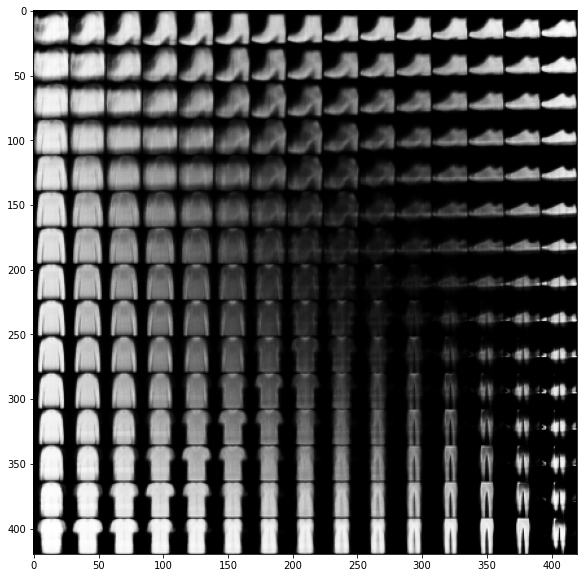

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt

n = 15         # figure with 15x15 digits
figure = np.zeros((28 * n, 28 * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28,
               j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()

In [ ]:
vae.losses

[<tf.Tensor 'Placeholder:0' shape=() dtype=float32>]